In [1]:
import sys, os
os.chdir('/Users/lananhnguyen/Desktop/thesis')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report, log_loss, make_scorer)
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [2]:
headline_cpi = pd.read_excel('Headline_HICP_yoy.xlsx')
headline_cpi.head()

,date,s1,s2zz,s2
0,1997-01-31,1.9,NaN,NaN
1,1997-02-28,1.6,1.0,NaN
2,1997-03-31,1.3,1.0,NaN
3,1997-04-30,1.2,1.0,NaN
4,1997-05-31,1.5,1.0,NaN


# 1. AR(p) model

Since we have covid period and it can mess with our data, we'll do:
split out-of-sampple forcasting into 3 periods: precovid, in covid and after covid.

In [4]:
headline_cpi.drop('s2zz', axis=1, inplace=True)
headline_cpi = headline_cpi.set_index('date')
headline_cpi = headline_cpi.asfreq('M')
headline_cpi.head()

,s1,s2
date,,
1997-01-31,1.9,NaN
1997-02-28,1.6,NaN
1997-03-31,1.3,NaN
1997-04-30,1.2,NaN
1997-05-31,1.5,NaN


In [5]:
headline_yoy = headline_cpi['s2'].dropna(axis = 0)
headline_yoy

date
1998-01-31   -1.2
1998-02-28   -1.1
1998-03-31   -0.8
1998-04-30   -0.3
1998-05-31   -0.6
             ... 
2023-01-31    4.1
2023-02-28    3.8
2023-03-31    0.2
2023-04-30   -0.2
2023-05-31   -2.4
Freq: M, Name: s2, Length: 305, dtype: float64

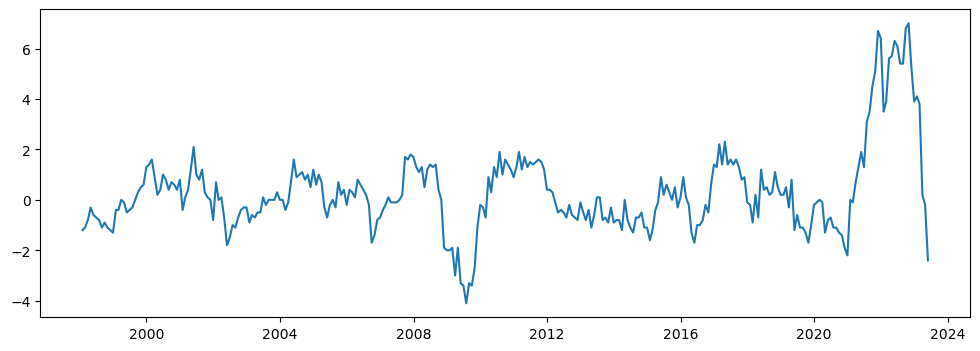

In [6]:
plt.figure(figsize = (12, 4))
plt.plot(headline_yoy)
plt.show()

In [10]:
headline_train = headline_yoy[headline_yoy.index <= '2015-12-31']

In [11]:
headline_test = headline_yoy[headline_yoy.index > '2015-12-31']
headline_t1 = headline_yoy[(headline_yoy.index > '2015-12-31') & (headline_yoy.index <= '2019-12-31')]
headline_t2 = headline_yoy[(headline_yoy.index > '2019-12-31') & (headline_yoy.index <= '2021-12-31')]
headline_t3 = headline_yoy[headline_yoy.index > '2021-12-31']
print('Pre-covid observations: ', len(headline_t1))
print('During covid observations: ', len(headline_t2))
print('After covid:' , len(headline_t3))


Pre-covid observations:  48
During covid observations:  24
After covid: 17


# 2. HICP

In [82]:
HICP_monthly = pd.read_excel('HICP_COICOP10s.xlsx', sheet_name='HICP_Monthly')
HICP_monthly.head()

,mdates,Rice,Rice.preparations,Flour,Semolina..rye.flour.or.the.like,White.bread,Rye.bread.or.brown.bread,Granary.bread.or.wholemeal.bread,Ready.to.bake.rolls,Fresh.bread.rolls,...,Premium.for.personal.liability.insurance,Premium.for.legal.protection.insurance,Bank.charges,Charge.for.tax.consultant.services,Charge.for.birth.certificate..death.certificate.or.the.like,Passport.fee.or.the.like,Fee.for.lawyer.s.or.notary.s.services,Charge.for.funeral.services.or.cemetery.fee,Classified.advertisement.in.a.newspaper,Visitor.s.tax
0,1996-01-31,86.699997,NaN,74.199997,83.900002,72.000000,72.000000,67.900002,NaN,62.200001,...,85.900002,44.0,104.900002,NaN,NaN,60.055096,62.408463,68.500000,64.099998,NaN
1,1996-02-29,86.699997,NaN,73.800003,83.900002,72.199997,72.099998,68.099998,NaN,62.299999,...,85.900002,44.0,104.900002,NaN,NaN,60.055096,62.408463,68.500000,64.099998,NaN
2,1996-03-31,86.699997,NaN,73.800003,83.900002,72.300003,72.300003,68.199997,NaN,62.400002,...,85.900002,44.0,104.900002,NaN,NaN,60.055096,62.408463,68.500000,64.099998,NaN
3,1996-04-30,86.699997,NaN,73.800003,83.900002,72.300003,72.300003,68.400002,NaN,62.400002,...,85.900002,44.0,104.900002,NaN,NaN,60.055096,62.408463,68.599998,64.099998,NaN
4,1996-05-31,86.699997,NaN,73.599998,83.900002,72.500000,72.300003,68.500000,NaN,62.400002,...,85.900002,44.0,104.900002,NaN,NaN,60.055096,62.408463,68.599998,64.199997,NaN


In [83]:
HICP_Weights = pd.read_excel('HICP_COICOP10s.xlsx', sheet_name='HICP_Weights')
HICP_Weights.head()

,mdates,Rice,Rice.preparations,Flour,Semolina..rye.flour.or.the.like,White.bread,Rye.bread.or.brown.bread,Granary.bread.or.wholemeal.bread,Ready.to.bake.rolls,Fresh.bread.rolls,...,Premium.for.personal.liability.insurance,Premium.for.legal.protection.insurance,Bank.charges,Charge.for.tax.consultant.services,Charge.for.birth.certificate..death.certificate.or.the.like,Passport.fee.or.the.like,Fee.for.lawyer.s.or.notary.s.services,Charge.for.funeral.services.or.cemetery.fee,Classified.advertisement.in.a.newspaper,Visitor.s.tax
0,1996-01-31,0.41,NaN,0.35,0.22,0.68,2.25,1.27,NaN,4.0,...,4.37,1.8,3.15,NaN,NaN,1.1,1.04,0.51,0.44,NaN
1,1996-02-29,0.41,NaN,0.35,0.22,0.68,2.25,1.27,NaN,4.0,...,4.37,1.8,3.15,NaN,NaN,1.1,1.04,0.51,0.44,NaN
2,1996-03-31,0.41,NaN,0.35,0.22,0.68,2.25,1.27,NaN,4.0,...,4.37,1.8,3.15,NaN,NaN,1.1,1.04,0.51,0.44,NaN
3,1996-04-30,0.41,NaN,0.35,0.22,0.68,2.25,1.27,NaN,4.0,...,4.37,1.8,3.15,NaN,NaN,1.1,1.04,0.51,0.44,NaN
4,1996-05-31,0.41,NaN,0.35,0.22,0.68,2.25,1.27,NaN,4.0,...,4.37,1.8,3.15,NaN,NaN,1.1,1.04,0.51,0.44,NaN


In [84]:
HICP_class = pd.read_excel('HICP_COICOP10s.xlsx', sheet_name='COICOP_class')
HICP_class = HICP_class
HICP_class.index = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
HICP_class.head()

,Rice,Rice.preparations,Flour,Semolina..rye.flour.or.the.like,White.bread,Rye.bread.or.brown.bread,Granary.bread.or.wholemeal.bread,Ready.to.bake.rolls,Fresh.bread.rolls,Yeast.pastry,...,Premium.for.personal.liability.insurance,Premium.for.legal.protection.insurance,Bank.charges,Charge.for.tax.consultant.services,Charge.for.birth.certificate..death.certificate.or.the.like,Passport.fee.or.the.like,Fee.for.lawyer.s.or.notary.s.services,Charge.for.funeral.services.or.cemetery.fee,Classified.advertisement.in.a.newspaper,Visitor.s.tax
Group 1,Food,Food,Food,Food,Food,Food,Food,Food,Food,Food,...,Non-food,Non-food,Non-food,Non-food,Non-food,Non-food,Non-food,Non-food,Non-food,Non-food
Group 2,Processed food,Processed food,Processed food,Processed food,Processed food,Processed food,Processed food,Processed food,Processed food,Processed food,...,Services,Services,Services,Services,Services,Services,Services,Services,Services,Services
Group 3,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,...,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services
Group 4,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,bread and cereals,...,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services,miscellaneous services


In [85]:
# HICP for categories:

HICP_food = pd.read_excel('HICP_food.xlsx')
HICP_food.head()

,date,s1,s2,comment
0,1996-01-31,0.0,NaN,NaN
1,1996-02-29,0.1,NaN,NaN
2,1996-03-31,0.9,NaN,NaN
3,1996-04-30,1.0,NaN,NaN
4,1996-05-31,0.3,NaN,NaN


In [86]:
HICP_class.columns.duplicated().any()

False

All product names are unique, so the name is enough for categorize, no need for id.

## 2.1. Data preparation:

Here is my approach for forecasting headline inflation:

First approach: 
1. Remove all columns that have missing values

2. Calculate year-on-year growth rate HICP_COICOP10 by:

a. Calculate the year-on-year growth rate for each month by subtracting the CPI index of the corresponding month in the previous year from the CPI index of the current year. Then divide the result by the CPI index of the previous year.

b. Express the year-on-year growth rate as a percentage by multiplying it by 100. 

3. Categorize all disagregated index into 4 ones: Food, Service, Energy and the rest.

Second approach: 
Same but with rolling window to gradually introduce new variables.

In [87]:
HICP_food = HICP_food.set_index('date')
food_series = HICP_food['s2'].dropna(axis = 0)

In [88]:
food_series

date
1997-01-31     1.2
1997-02-28     0.6
1997-03-31    -1.2
1997-04-30    -1.1
1997-05-31     0.7
              ... 
2023-02-28    16.2
2023-03-31    15.9
2023-04-30     9.5
2023-05-31     4.6
2023-06-30     2.0
Name: s2, Length: 318, dtype: float64

In [89]:
HICP_monthly.isna().sum()

mdates                                           0
Rice                                             0
Rice.preparations                              228
Flour                                            0
Semolina..rye.flour.or.the.like                  0
                                              ... 
Passport.fee.or.the.like                         0
Fee.for.lawyer.s.or.notary.s.services            0
Charge.for.funeral.services.or.cemetery.fee      0
Classified.advertisement.in.a.newspaper          0
Visitor.s.tax                                  228
Length: 645, dtype: int64

In [92]:
HICP_monthly.dropna(axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Columns: 492 entries, mdates to Classified.advertisement.in.a.newspaper
dtypes: datetime64[ns](1), float64(491)
memory usage: 1.2 MB


In [ ]:
HICP_yoy = pd.DataFrame()
HICP_yoy = (HICP_monthly.iloc[:, 1:].pct_change(12) * 100) #year-on-year percentage change
HICP_yoy['date'] = HICP_monthly['mdates']
HICP_yoy = HICP_yoy.set_index('date').dropna()

In [ ]:
HICP_yoy.head(20)

In [ ]:
# Extract data into groups:
# Full data groups: 

food_f = HICP_class.loc[:, HICP_class.iloc[0, :] == 'Food']
services_f = HICP_class.loc[:, HICP_class.iloc[1, :] == 'Services']
energy_f = HICP_class.loc[:, HICP_class.iloc[1, :] == 'Energy']
negi_f = HICP_class.loc[:, HICP_class.iloc[1, :] == 'Non-energy industrial goods (NEIG)']

print('Number of items in food group: ', food_f.shape[1])
print('Number of items in services group: ', services_f.shape[1])
print('Number of items in energy group: ', energy_f.shape[1])
print('Number of items in Non-energy industrial goods (NEIG) group: ', negi_f.shape[1])
print('Total: ', food_f.shape[1] + services_f.shape[1]+ negi_f.shape[1] + energy_f.shape[1])

In [ ]:
food_f.columns

In [ ]:
# Second groups is for sets that doesn't contain missing values, so subset columns must appear in both df

food = HICP_yoy[HICP_yoy.columns.intersection(food_f.columns)]
services = HICP_yoy[HICP_yoy.columns.intersection(services_f.columns)]
energy = HICP_yoy[HICP_yoy.columns.intersection(energy_f.columns)]
negi = HICP_yoy[HICP_yoy.columns.intersection(negi_f.columns)]

print('Number of items in food group: ', food.shape[1])
print('Number of items in services group: ', services.shape[1])
print('Number of items in energy group: ', energy.shape[1])
print('Number of items in Non-energy industrial goods (NEIG) group: ', negi.shape[1])
print('Total: ', food.shape[1] + services.shape[1]+ negi.shape[1] + energy.shape[1])

In [ ]:
food.head()

In [ ]:
# Divide into train and test set

X_food_train = food[food.index <= '2015-12-31']
X_food_test = food[food.index > '2015-12-31']

#X_food_test = food[(food.index > '2015-12-31') & (food.index <= '2019-12-31')]
#food_df_t2 = food[(food.index > '2019-12-31') & (food.index <= '2021-12-31')]
#food_df_t3 = food[food.index > '2021-12-31']


services_train = services[services.index <= '2015-12-31']
services_t1 = services[(services.index > '2015-12-31') & (services.index <= '2019-12-31')]
services_t2 = services[(services.index > '2019-12-31') & (services.index <= '2021-12-31')]
services_t3 = services[services.index > '2021-12-31']


energy_train = energy[energy.index <= '2015-12-31']
energy_t1 = energy[(energy.index > '2015-12-31') & (energy.index <= '2019-12-31')]
energy_t2 = energy[(energy.index > '2019-12-31') & (energy.index <= '2021-12-31')]
energy_t3 = energy[energy.index > '2021-12-31']


negi_train = negi[negi.index <= '2015-12-31']
negi_t1 = negi[(negi.index > '2015-12-31') & (negi.index <= '2019-12-31')]
negi_t2 = negi[(negi.index > '2019-12-31') & (negi.index <= '2021-12-31')]
negi_t3 = negi[negi.index > '2021-12-31']

In [ ]:
X_food_train = food[food.index <= '2015-12-31']
X_food_test = food[food.index > '2015-12-31']

y_food_train = food_series[food_series.index <= '2015-12-31']
y_food_test = food_series[food_series.index > '2015-12-31']

In [ ]:
# Need to know how much lag of food should I add into the model:

stepwise_model = pm.auto_arima(y_food_train, 
                            start_p=1, start_q=0,
                           max_p=12, max_q=0, m=12,
                           start_P=1, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                            information_criterion='bic') 
print(stepwise_model.bic())

Here it also have seasonal components. what can I do with it???
Should I do smoothing, or shit before I do that? 

## 2.2. Feature extraction:
Let's do PCA, with food first. Here I need to do:


1. Split the Data: Split your data into training and testing sets.
2. Scale the Data: Apply scaling separately to the training and test data.
3. Apply PCA: Apply PCA on the scaled training data.
4. Transform Test Data: Use the PCA model trained on the scaled training data to transform the scaled test data.
5. Perform Linear Regression: Use the transformed training data to perform linear regression.
6. Predict and Combine: Make predictions on the transformed test data and combine the results with additional time series data.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd


# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_food_train)
X_test_scaled = scaler.transform(X_food_test)

# Apply PCA
pca = PCA(n_components=18)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Add yt-1 lag into the X_df



# Create a Linear Regression model and fit it
lr_model = LinearRegression()
lr_model.fit(X_train_pca, y_train)

# Predict using the linear regression model
y_pred = lr_model.predict(X_test_pca)



In [ ]:
# Scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [ ]:
per_var = np.round(explained_variance_ratio*100, decimals = 1)[:18]
plt.bar(x = range(1, len(per_var)+1), height = per_var)
plt.show()

In [ ]:
food_reduced_df.shape

In [ ]:
food_series_train

Now since we reduced the dimension from 491 to 18, let's feed it to some models.
Maybe should set up a pipeline to do the job????

But first, let's try feed food_train without any lags to the rf.
Now what should I do? For example: I can do RF in 2 ways:
- Adding lags to the df and run the model once, and try to predict in the test set.
-> always try to keep out-of-sample forecast, as 1, 2, 3 steps ahead.

In [ ]:
my_rf = RandomForestRegressor(n_estimators=100)
my_rf.fit(food_df_train, food_series_train)
fcst = my_rf.predict(X_test)